In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


import pyro
import pyro.distributions as dist 
from  pyro.distributions import TransformedDistribution
from torch.distributions import Transform
from  pyro.distributions.transforms import ExpTransform
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal,AutoLowRankMultivariateNormal,  AutoGuideList, AutoLaplaceApproximation
import torch.distributions.constraints as constraints
import torch
from pyro import poutine

In [2]:
zeisel = pd.read_csv("Zeisel_UMI_counts.txt", sep = "\t")
zeisel = zeisel.set_index("GeneID").T
cnt_mat = zeisel.to_numpy()

In [3]:
zsan = pd.read_csv("Zeisel_Sanity_normalization.txt", sep = "\t")
zsan = zsan.set_index("GeneID").T
cnt_mat_san = zsan.to_numpy()

In [4]:
gene = "Zbed3"

n_g = zeisel[gene].values
N_c = cnt_mat.sum(axis = 1)

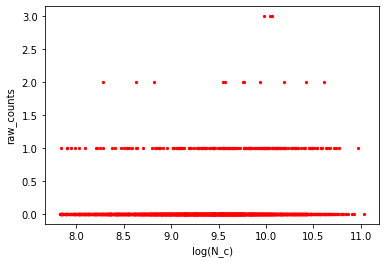

In [5]:
plt.scatter(np.log(N_c), n_g, c = "r", s = 5)
plt.ylabel("raw_counts")
plt.xlabel("log(N_c)");

In [6]:

def sanity_model(n_g, N_c):
    """
    n_g - is the vector of counts of gene g across all cells is the observed data
    N_c - is the total count of gene transcripts in a given cell.
    
    """
    min_val_log = torch.tensor([0.001]).log().cuda()
    max_val_log = torch.tensor([50.]).log().cuda()
    un0 = torch.tensor([0.0]).cuda()
    un1 = torch.tensor([1.0]).cuda()
    loc_0 = torch.tensor([0.]).cuda()
    
    α_g = pyro.sample("α_g", dist.Uniform(un0, un1))
    v_gi = pyro.sample("v_gi", dist.Uniform(min_val_log, max_val_log))
    v_g = torch.exp(v_gi)
        
    
    cell_plate = pyro.plate("cell_plate", size = n_g.shape[0])
    
    with cell_plate:
        δ_gc = pyro.sample("fold_change_each_cell", dist.Normal(loc = loc_0, scale = v_g))
        α_gc = α_g*torch.exp(δ_gc)
        counts = pyro.sample("obs", dist.Poisson(rate = N_c*α_gc), obs=n_g)
        
       

In [7]:
def init_loc_fn(site):
    shape = site["fn"].shape()
    
    if site["name"] == "α_g":
        return torch.tensor([.001]).cuda()
    if site["name"] == "v_gi":
        return torch.tensor([.2]).cuda()
    if site["name"] == "fold_change_each_cell":
        return dist.Normal(-2, 2).sample((len(n_g), )).cuda()
    raise NotImplementedError(f"TODO initialize latent variable {site['name']}")

In [8]:
#guide = AutoNormal(sanity_model, init_loc_fn=init_loc_fn, init_scale = .01)

#guide = AutoLowRankMultivariateNormal(sanity_model, init_loc_fn = init_loc_fn, rank = 200)
guide = AutoGuideList(sanity_model)
guide.append(AutoNormal(poutine.block(sanity_model, expose=["α_g"]), init_scale = 1e-5, init_loc_fn = init_loc_fn))
guide.append(AutoNormal(poutine.block(sanity_model, expose=["v_gi"]), init_scale = 1e-2, init_loc_fn = init_loc_fn))
guide.append(AutoLowRankMultivariateNormal(poutine.block(sanity_model, expose=["fold_change_each_cell"]), init_scale = 1e-1, init_loc_fn = init_loc_fn) )

In [9]:
adam = Adam({"lr": 1e-2})
svi = SVI(sanity_model, guide, adam, loss=Trace_ELBO())

In [10]:
pyro.clear_param_store()
num_iterations = 15000
n_gt = torch.tensor(n_g).cuda()
N_ct = torch.tensor(N_c).cuda()
losses = []
for j in tqdm(range(num_iterations)):
    # calculate the loss and take a gradient step
    loss = svi.step(n_gt, N_ct)
    losses.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:45<00:00, 52.53it/s]


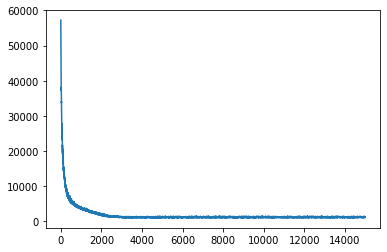

In [11]:
plt.plot(losses)

#### get posterior samples

In [12]:
alpha_gs = []
v_gs = []
delta_gcs = []
for _ in tqdm(range(8000)):
    estimates = guide(n_gt, N_ct)
    alpha_g = estimates["α_g"].detach().cpu().numpy().item()
    v_g = estimates["v_gi"].detach().cpu().numpy().item()
    delta_gc = estimates["fold_change_each_cell"].detach().cpu().numpy()
    alpha_gs.append(alpha_g)
    delta_gcs.append(delta_gc)
    v_gs.append(v_g)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:15<00:00, 512.84it/s]


In [13]:
delta_gcs_post = np.asarray(delta_gcs).mean(axis = 0)
alpha_g_post = np.mean(alpha_gs)
delta_gcs_post.shape, alpha_g_post

((3005,), 3.322136224227279e-06)

Text(8, -10.7, 'R_sanity : -0.035')

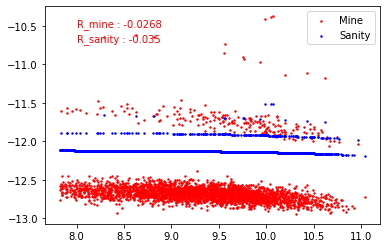

In [14]:

vals = np.log(alpha_g_post*np.exp(delta_gcs_post))
R_mine = np.corrcoef(vals, np.log(N_c))[0, 1]
R_paper = -0.035 

plt.scatter(np.log(N_c), vals, c= "r", s = 2, label = "Mine")
plt.scatter(np.log(N_c), zsan[gene], c= "b", s = 2, label = "Sanity")
plt.legend()
plt.text(8, -10.5, f"R_mine : {round(R_mine, 4)}", {"color":"r"})
plt.text(8, -10.7, f"R_sanity : {R_paper}", {"color": "r"})

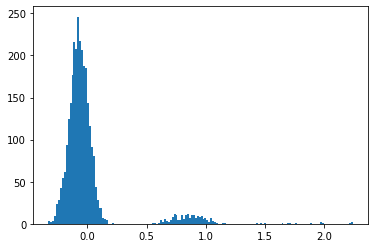

In [15]:
plt.hist(delta_gcs_post, bins ="auto");